In [2]:
%load_ext autoreload
%autoreload 2

from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal

import os
import sys
module_path = os.path.abspath(os.path.join('/workspaces/pose'))
if module_path not in sys.path:
    sys.path.insert(0, '/workspaces/pose')

from pose import abelian_utils, fourier_utils3, hex_utils

In [2]:
domain = np.array([1.0, sqrt(3)/2, 1.0])
fourier_coef_shape = (8, 8, 8)  # maintain fourier_coef_shape[0] == fourier_coef_shape[1] to get correct periodicity
# cov = 0.06 * np.eye(3)
cov = 0.03 * np.eye(3)
generators = np.array([[1, 0.5, 0], [0, sqrt(3)/2, 0], [0, 0, 1]])
# generators = np.array([[1.5, 0.5, 0], [0, sqrt(3)/2, 0], [0, 0, 1.8]])
generators = generators / np.array(fourier_coef_shape)  # -> domain = np.array([1,sqrt(3)/2,1])

XXX, YYY, ZZZ = abelian_utils.get_3d_coordinates_unwrapped_vectorized(fourier_coef_shape, generators)

In [3]:
u_diff, v_diff, w_diff = hex_utils.get_3d_distances(*fourier_coef_shape)
pos = np.stack((u_diff[0], v_diff[0], w_diff[0]), axis=-1)
# pos = np.stack((u_diff[0]+0.16, v_diff[0]+0.17, w_diff[0]+0.18), axis=-1)
Z = multivariate_normal.pdf(x=pos, mean=np.zeros(3), cov=cov).reshape(fourier_coef_shape)
Z = abelian_utils.unwrap_single(Z, fourier_coef_shape, 1)  # confirmed correct with MATLAB

In [4]:
zero_coefs = np.fft.fftn(Z, s=fourier_coef_shape, norm='forward') * np.prod(domain)
zero_coefs2 = np.fft.rfftn(Z, s=fourier_coef_shape, norm='forward') * np.prod(domain)
zero_coefs_cropped = abelian_utils.crop_conjugate_symmetry(zero_coefs, fourier_coef_shape)
zero_coefs_flattened = abelian_utils.flatten_coefs(zero_coefs_cropped)
zero_bump_reconstructed = np.fft.ifftn(zero_coefs, s=fourier_coef_shape, norm='forward') / np.prod(domain)
zero_bump_reconstructed2 = np.fft.irfftn(zero_coefs_cropped, s=fourier_coef_shape, norm='forward') / np.prod(domain)
print(np.allclose(zero_coefs2, zero_coefs_cropped, rtol=1e-10, atol=1e-10))
print(np.allclose(zero_bump_reconstructed, zero_bump_reconstructed2, rtol=1e-10, atol=1e-10))

True
True


In [47]:
np.allclose(zero_coefs_flattened, abelian_utils.restore_nyquist(abelian_utils.get_0_coefs(fourier_coef_shape, cov), fourier_coef_shape), rtol=1e-16, atol=1e-16)

True

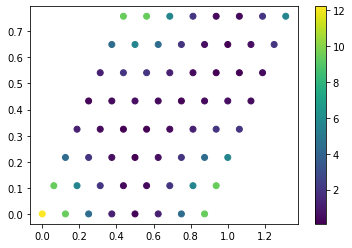

In [5]:
plt.scatter(XXX[:,:,0], YYY[:,:,0], c=Z[:,:,0])
plt.colorbar()

In [6]:
# u_diff_unwrapped = abelian_utils.unwrap_multi(u_diff.reshape((*fourier_coef_shape, *fourier_coef_shape)), fourier_coef_shape, 1).reshape((np.prod(fourier_coef_shape), np.prod(fourier_coef_shape)))
# v_diff_unwrapped = abelian_utils.unwrap_multi(v_diff.reshape((*fourier_coef_shape, *fourier_coef_shape)), fourier_coef_shape, 1).reshape((np.prod(fourier_coef_shape), np.prod(fourier_coef_shape)))
# print(u_diff_unwrapped[0].reshape(fourier_coef_shape))
# print(v_diff_unwrapped[0].reshape(fourier_coef_shape))

In [7]:
shift = np.array([domain[0]/fourier_coef_shape[0], domain[1]/fourier_coef_shape[1], domain[2]/fourier_coef_shape[0]])
rot_mat = fourier_utils3._rot_mat_complete(fourier_coef_shape, shift)
zero_coefs_rotated_flattened = rot_mat.dot(zero_coefs_flattened)
zero_coefs_rotated_cropped = abelian_utils.unflatten_coefs(zero_coefs_rotated_flattened, fourier_coef_shape).reshape(fourier_coef_shape[0], fourier_coef_shape[1], fourier_coef_shape[2]//2+1)
zero_coefs_rotated = abelian_utils.append_conjugate_symmetry(zero_coefs_rotated_cropped, fourier_coef_shape)

In [8]:
zero_bump_rotated_reconstructed = np.fft.ifftn(zero_coefs_rotated, s=fourier_coef_shape, norm='forward') / np.prod(domain)
zero_bump_rotated_reconstructed2 = np.fft.irfftn(zero_coefs_rotated_cropped, s=fourier_coef_shape, norm='forward') / np.prod(domain)
print(np.allclose(zero_bump_rotated_reconstructed, zero_bump_rotated_reconstructed2, rtol=1e-10, atol=1e-10))

True


/usr/local/lib/python3.10/site-packages/matplotlib/axes/_axes.py:4147: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)


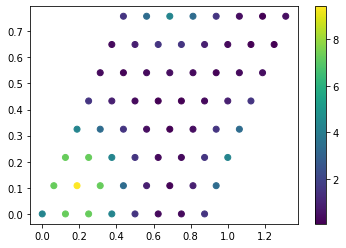

In [9]:
plt.scatter(XXX[:,:,0], YYY[:,:,0], c=zero_bump_rotated_reconstructed[:,:,0])
plt.colorbar()

In [10]:
Z_rolled = np.roll(Z, shift=(1,1,1), axis=(0,1,2))
zero_coefs_rolled = np.fft.fftn(Z_rolled, s=fourier_coef_shape, norm='forward') * np.prod(domain)
zero_coefs_rolled2 = np.fft.rfftn(Z_rolled, s=fourier_coef_shape, norm='forward') * np.prod(domain)
zero_bump_rolled_reconstructed = np.fft.ifftn(zero_coefs_rolled, s=fourier_coef_shape, norm='forward') / np.prod(domain)
print(np.allclose(zero_coefs_rolled2, zero_coefs_rotated_cropped, rtol=1e-10, atol=1e-10))

True


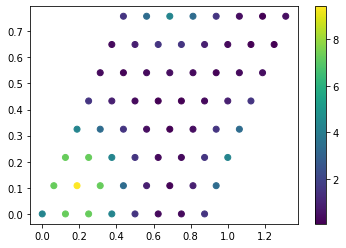

In [11]:
plt.scatter(XXX[:,:,0], YYY[:,:,0], c=Z_rolled[:,:,0])
plt.colorbar()

In [12]:
print(np.allclose(zero_coefs_rolled, zero_coefs_rotated, rtol=1e-10, atol=1e-10))
print(np.allclose(Z_rolled, zero_bump_rotated_reconstructed, rtol=1e-10, atol=1e-10))

True
True


In [16]:
def get_nyquist_mask(fourier_coef_shape):
    mask = np.ones((fourier_coef_shape[0], fourier_coef_shape[1], fourier_coef_shape[2]//2+1), dtype=bool)
    mask2 = mask.flatten()

    for idx_x in range(fourier_coef_shape[0]):
        for idx_y in range(fourier_coef_shape[1]):
            for idx_z in range(fourier_coef_shape[2]):
                if (idx_x == 0 or (fourier_coef_shape[0] % 2 == 0 and idx_x == fourier_coef_shape[0]//2)) and (idx_y == 0 or (fourier_coef_shape[1] % 2 == 0 and idx_y == fourier_coef_shape[1]//2)) and (idx_z == 0 or (fourier_coef_shape[2] % 2 == 0 and idx_z == fourier_coef_shape[2]//2)):
                    mask[idx_x, idx_y, idx_z] = 0

    mask = mask.flatten()
    mask_flat = np.stack((mask2, mask), 1).flatten()  # duplicate mask since separate real and imag parts

    return mask_flat

In [44]:
abelian_utils.get_nyquist_mask(fourier_coef_shape).sum()

632

In [37]:
def remove_nyquist(coef_flat_cropped, fourier_coef_shape):
    """takes coefs of the shape (2*fourier_coef_shape[0]*fourier_coef_shape[1]*(fourier_coef_shape[2]//2+1),) and removes the imaginary parts corresponding to Nyquist locations"""

    mask_flat = np.invert(abelian_utils.get_nyquist_mask(fourier_coef_shape))
    coef_final = np.delete(coef_flat_cropped, mask_flat, axis=0)
    return coef_final

In [38]:
zero_coefs3 = abelian_utils.get_0_coefs(fourier_coef_shape, cov, None)
print(zero_coefs3.shape)
print(remove_nyquist(zero_coefs3, fourier_coef_shape).shape)

(640,)
(632,)


In [41]:
def restore_nyquist(coefs_final, fourier_coef_shape):
    indices = np.arange(fourier_coef_shape[0] * fourier_coef_shape[1] * (fourier_coef_shape[2]//2+1) * 2)
    mask_flat = np.invert(abelian_utils.get_nyquist_mask(fourier_coef_shape))
    indices_cropped = np.delete(indices, mask_flat, axis=0)

    coefs_flat_cropped = np.zeros((fourier_coef_shape[0] * fourier_coef_shape[1] * (fourier_coef_shape[2]//2+1) * 2), dtype=coefs_final.dtype)
    coefs_flat_cropped[indices_cropped] = coefs_final
    
    return coefs_flat_cropped

In [43]:
np.allclose(zero_coefs3, restore_nyquist(remove_nyquist(zero_coefs3, fourier_coef_shape), fourier_coef_shape), rtol=1e-10, atol=1e-10)

True

In [23]:
get_nyquist_mask((6,6,6)).reshape((6,6,4,2))

array([[[[ True, False],
         [ True,  True],
         [ True,  True],
         [ True, False]],

        [[ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True]],

        [[ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True]],

        [[ True, False],
         [ True,  True],
         [ True,  True],
         [ True, False]],

        [[ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True]],

        [[ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True]]],


       [[[ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True]],

        [[ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True]],

        [[ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True]],

        [[ True,  True],
         [ True,  True],
         [ True,  True],
     

In [11]:
neuron_shape = (4,4,4)
fourier_coef_shape2 = (4,4,4)
cov2 = 0.05 * np.eye(3)
encoders = abelian_utils.get_encoders(neuron_shape, fourier_coef_shape2, cov2)
generators2 = np.array([[1, 0.5, 0], [0, sqrt(3)/2, 0], [0, 0, 1]])
generators2 = generators2 / np.array(fourier_coef_shape2)
XXX2, YYY2, ZZZ2 = abelian_utils.get_3d_coordinates_unwrapped_vectorized(fourier_coef_shape2, generators2)

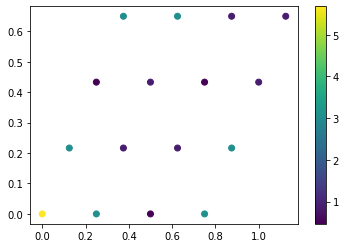

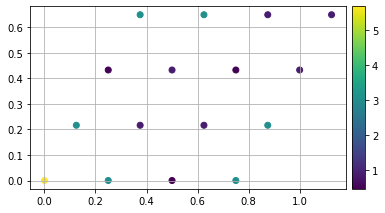

In [17]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

encoder_bump = abelian_utils.reconstruct_primal(encoders[0], fourier_coef_shape2)
# plt.scatter(XXX2[:,:,0], YYY2[:,:,0], c=encoder_bump[:,:,0])
# plt.colorbar()

f, ax1 = plt.subplots(1, 1, sharex=True, sharey=True)
ax1.set_aspect('equal', 'box')
sc1 = ax1.scatter(XXX2[:,:,0], YYY2[:,:,0], c=encoder_bump[:,:,0], cmap='viridis')
ax1.grid()
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("right", size="4%", pad="2%")
f.colorbar(sc1, cax=cax1)

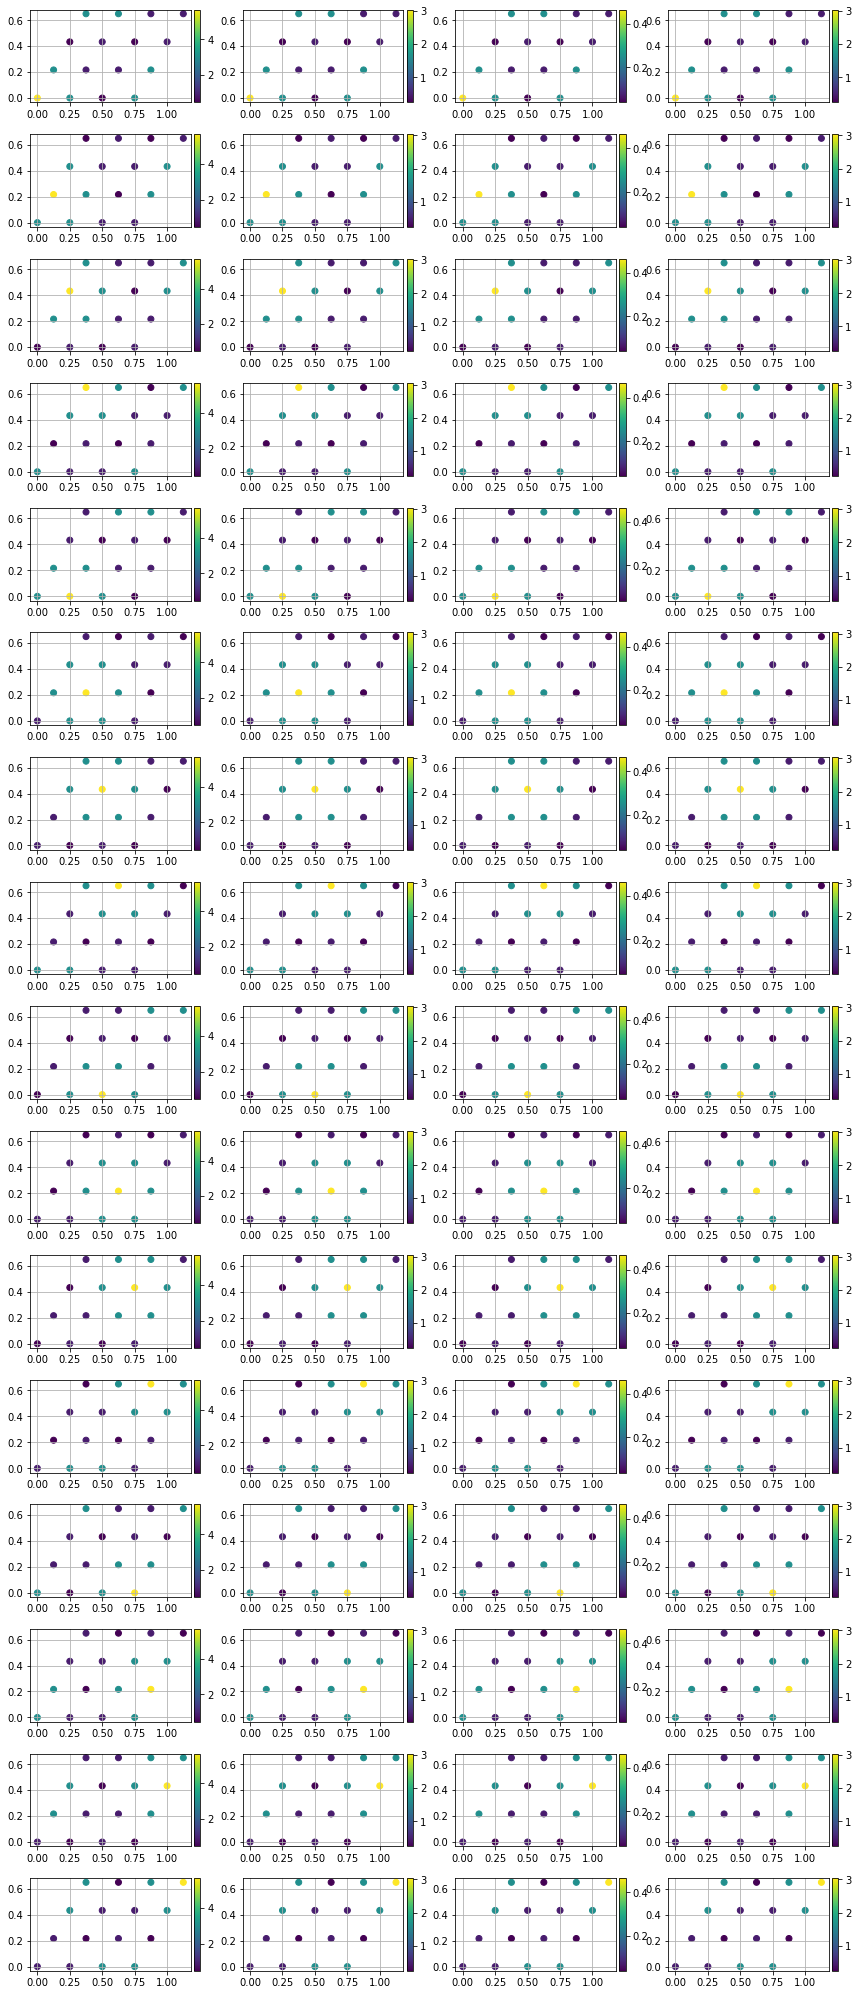

In [35]:
# slice horizontally -> view from top

mm = 1/25.4  # centimeters in inches
fig, axs = plt.subplots(nrows=neuron_shape[0]*neuron_shape[1], ncols=neuron_shape[2], constrained_layout=True, figsize=(300*mm,700*mm), gridspec_kw = {'wspace': 0.03, 'hspace': 0.12})
for x in range(neuron_shape[0]):
    for y in range(neuron_shape[1]):
        for z in range(neuron_shape[2]):
            ax = axs[x*neuron_shape[1]+y, z]
            ax.set_aspect('equal', 'box')
            ax.grid()

            _encoder_bump = abelian_utils.reconstruct_primal(encoders[x*neuron_shape[1]*neuron_shape[2]+y*neuron_shape[2]+z], fourier_coef_shape2)
            sc = ax.scatter(XXX2[:,:,0], YYY2[:,:,0], c=_encoder_bump[:,:,0])
            
            ax_divider = make_axes_locatable(ax)
            cax = ax_divider.append_axes("right", size="4%", pad="2%")
            f.colorbar(sc, cax=cax)

# plt.colorbar()

In [39]:
_encoder_bump = abelian_utils.reconstruct_primal(encoders[0*neuron_shape[1]*neuron_shape[2]+2*neuron_shape[2]+0], fourier_coef_shape2)
_encoder_bump[:,:,0]
# XXX2[:,:,0]

array([[0.46616427, 3.03977291, 5.67904344, 3.03977291],
       [0.87090952, 3.03977291, 3.03977291, 0.87090952],
       [0.46616427, 0.87090952, 0.46616427, 0.87090952],
       [0.87090952, 0.87090952, 3.03977291, 3.03977291]])

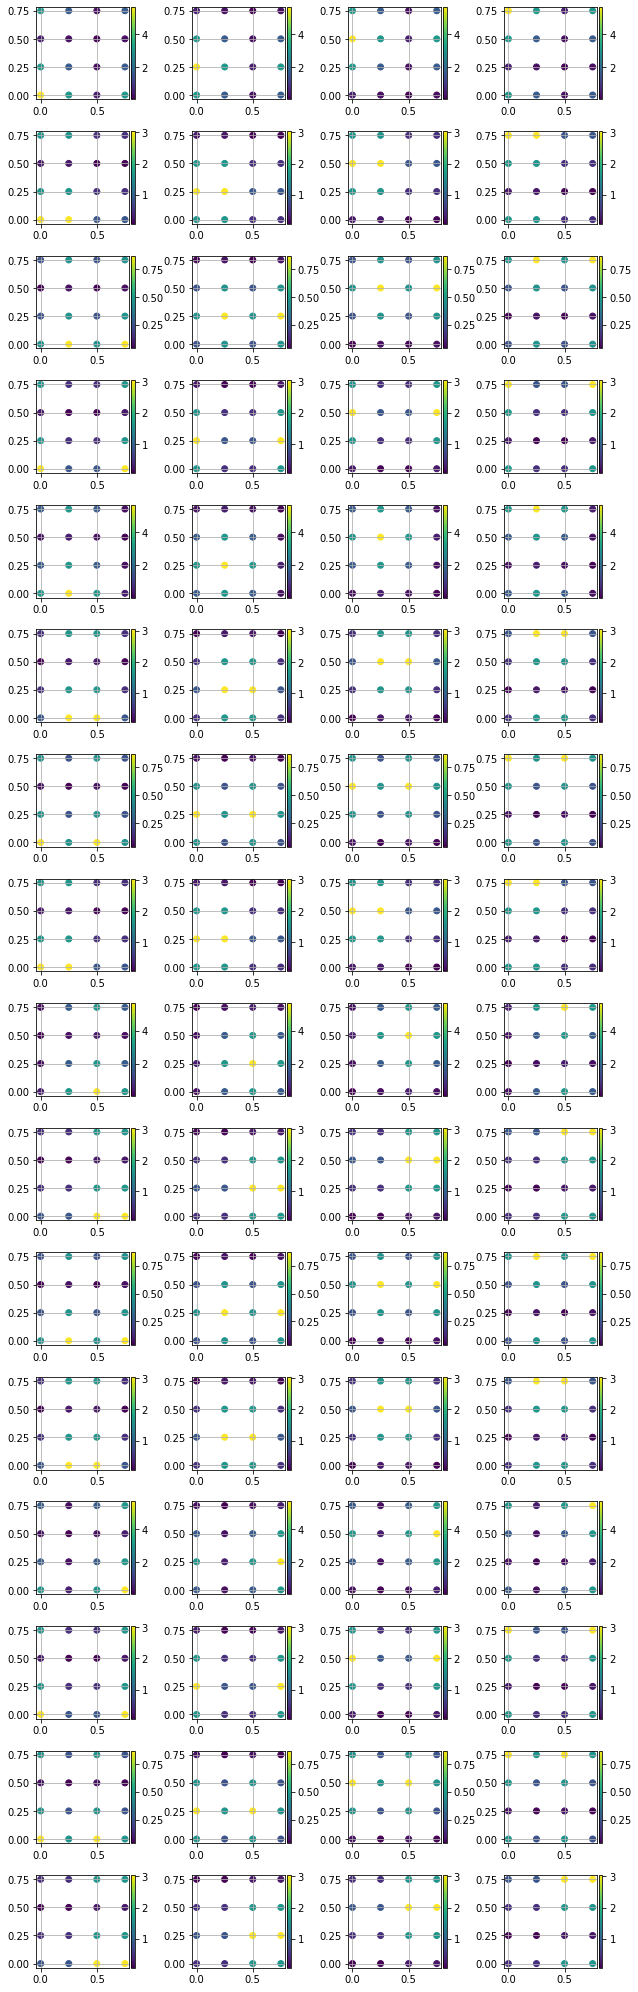

In [33]:
# slice vertically -> view from front

mm = 1/25.4  # centimeters in inches
fig, axs = plt.subplots(nrows=neuron_shape[0]*neuron_shape[1], ncols=neuron_shape[2], constrained_layout=True, figsize=(220*mm,700*mm), gridspec_kw = {'wspace': 0.03, 'hspace': 0.12})
for x in range(neuron_shape[0]):
    for y in range(neuron_shape[1]):
        for z in range(neuron_shape[2]):
            ax = axs[x*neuron_shape[1]+y, z]
            ax.set_aspect('equal', 'box')
            ax.grid()

            _encoder_bump = abelian_utils.reconstruct_primal(encoders[x*neuron_shape[1]*neuron_shape[2]+y*neuron_shape[2]+z], fourier_coef_shape2)
            sc = ax.scatter(XXX2[:,0,:], ZZZ2[:,0,:], c=_encoder_bump[:,0,:])
            
            ax_divider = make_axes_locatable(ax)
            cax = ax_divider.append_axes("right", size="4%", pad="2%")
            f.colorbar(sc, cax=cax)

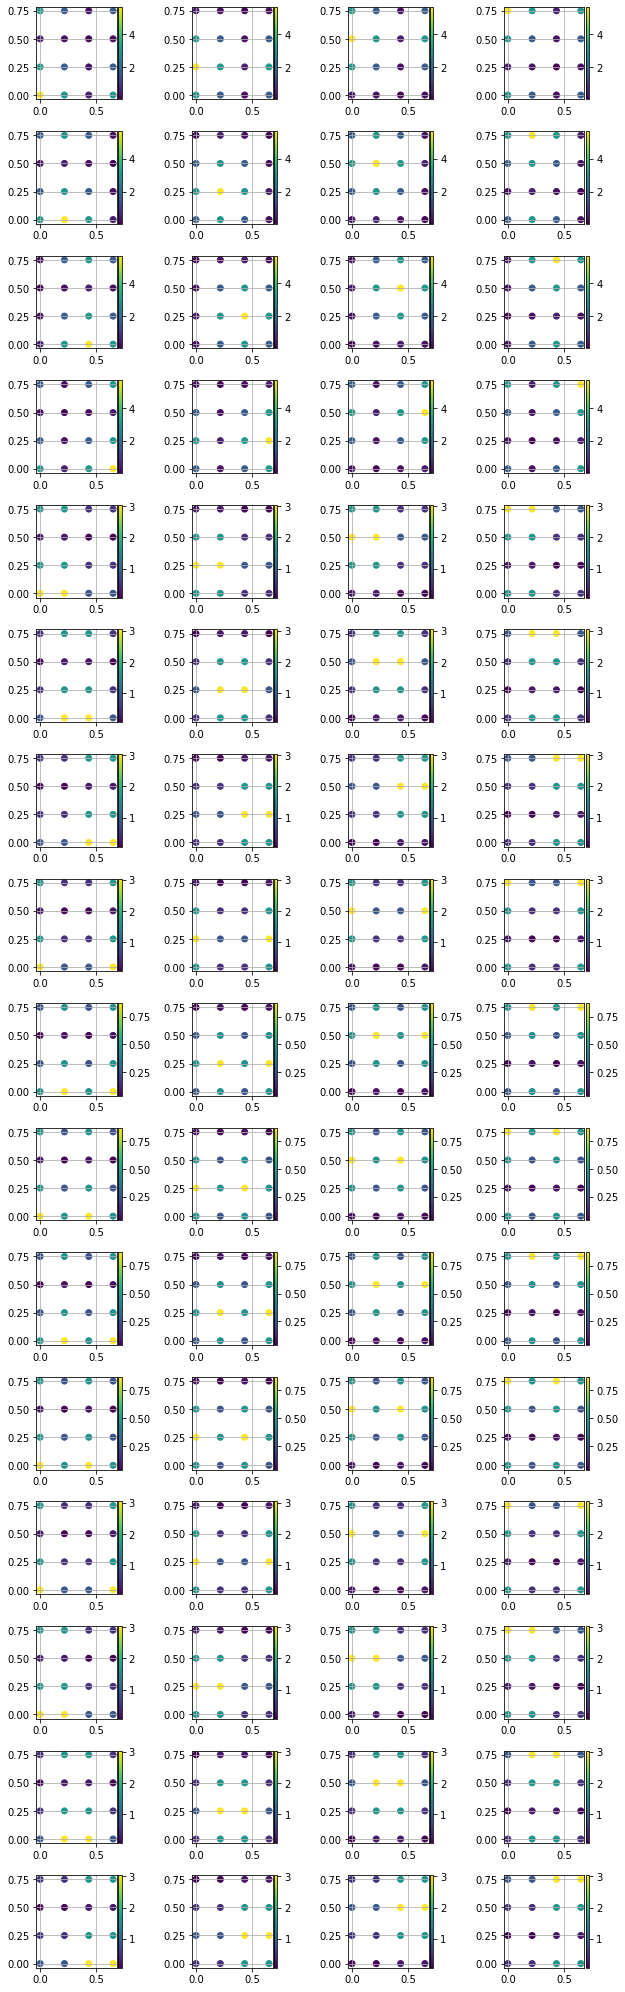

In [40]:
# slice vertically -> view from right

mm = 1/25.4  # centimeters in inches
fig, axs = plt.subplots(nrows=neuron_shape[0]*neuron_shape[1], ncols=neuron_shape[2], constrained_layout=True, figsize=(220*mm,700*mm), gridspec_kw = {'wspace': 0.03, 'hspace': 0.12})
for x in range(neuron_shape[0]):
    for y in range(neuron_shape[1]):
        for z in range(neuron_shape[2]):
            ax = axs[x*neuron_shape[1]+y, z]
            ax.set_aspect('equal', 'box')
            ax.grid()

            _encoder_bump = abelian_utils.reconstruct_primal(encoders[x*neuron_shape[1]*neuron_shape[2]+y*neuron_shape[2]+z], fourier_coef_shape2)
            sc = ax.scatter(YYY2[0,:,:], ZZZ2[0,:,:], c=_encoder_bump[0,:,:])
            
            ax_divider = make_axes_locatable(ax)
            cax = ax_divider.append_axes("right", size="4%", pad="2%")
            f.colorbar(sc, cax=cax)

In [132]:
rec_con_weights = abelian_utils.get_rec_con_weights(neuron_shape)

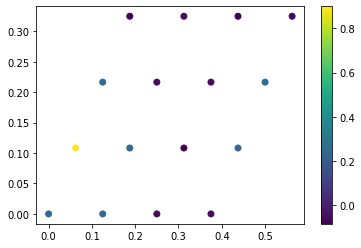

In [133]:
plt.scatter(XXX2[:,:,0], YYY2[:,:,0], c=rec_con_weights[4].reshape(neuron_shape)[:,:,0])
plt.colorbar()

In [106]:
np.allclose(encoder_bump[:,:,0], rec_con_weights[0].reshape(neuron_shape)[:,:,0])

True

In [157]:
encoders_pose = abelian_utils.get_encoders(neuron_shape, fourier_coef_shape2, cov)
encoders_pose

array([[ 9.75428131e-01,  5.57916071e-01,  0.00000000e+00, ...,
        -2.70416628e-17,  8.20728071e-02, -1.50231460e-17],
       [ 9.75428131e-01,  3.41625065e-17, -5.57916071e-01, ...,
        -2.60838433e-01, -8.20728071e-02,  4.97212593e-18],
       [ 9.75428131e-01, -5.57916071e-01, -6.83250131e-17, ...,
        -4.90183241e-18,  8.20728071e-02,  5.07889412e-18],
       ...,
       [ 9.75428131e-01,  3.41625065e-17, -5.57916071e-01, ...,
         2.60838433e-01,  8.20728071e-02, -3.51251861e-17],
       [ 9.75428131e-01, -5.57916071e-01, -6.83250131e-17, ...,
        -9.09286532e-17, -8.20728071e-02,  2.50741660e-17],
       [ 9.75428131e-01, -1.02487520e-16,  5.57916071e-01, ...,
        -2.60838433e-01,  8.20728071e-02, -1.50231460e-17]])

In [156]:
np.amax(encoders_pose, axis=0, keepdims=True).max()

0.9754281310721439

In [158]:
tmp13 = np.amax(encoders_pose, axis=0, keepdims=True)
scale_fact_pose1 = 1.0/tmp13
encoders_pose_scaled = encoders_pose * scale_fact_pose1

scale_fact_pose2 = 1.0 / np.amax(np.linalg.norm(encoders_pose_scaled, axis=1, keepdims=True))
encoders_pose_scaled *= scale_fact_pose2

scale_fact_pose = scale_fact_pose1 * scale_fact_pose2

In [160]:
np.allclose(encoders_pose, encoders_pose_scaled / scale_fact_pose)

True